# Score-Based Models
In this notebook, we delve into the fundamentals of score-based models.
Through interactive visualizations, we provide intuitive insights into score-fields, the process of score function training, and sampling methods like Langevin dynamics. This notebook aims to build a deeper understanding of the theoretical underpinnings of the score-based models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


## Data Generation

In [2]:
student_number = 810103326

Generate parameters of mixture of two Gaussians based on the `student_number`.

*Note: This section involves random parameter generation and doesn't require detailed attention.*

In [3]:
# Set random seed
np.random.seed(student_number)

# Mixture coefficients
w1 = 0.15 + np.random.rand() * 0.1
w2 = 1 - w1

# Gaussian placements
if np.random.choice(2):
    mean1, mean2 = [-5, 5], [5, -5]
else:
    mean1, mean2 = [5, 5], [-5, -5]

# Swap dominant
if np.random.choice(2):
    w1, w2 = w2, w1

# Covariance
var1 = 1 + np.random.rand()
var2 = 1 + np.random.rand()

cov1 = [[var1, 0], [0, var1]]
cov2 = [[var2, 0], [0, var2]]


Define the PDF

In [4]:
def gaussian_pdf(x, mean, cov):
    dim = len(mean)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1 / (np.sqrt((2 * np.pi)**dim * det_cov))
    diff = x - mean
    return norm_const * np.exp(-0.5 * diff @ inv_cov @ diff.T)

# Define the PDF function
def p_x(x, y):
    point = np.array([x, y])
    pdf1 = w1 * gaussian_pdf(point, mean1, cov1)
    pdf2 = w2 * gaussian_pdf(point, mean2, cov2)
    return pdf1 + pdf2



Visualization of the Distribution

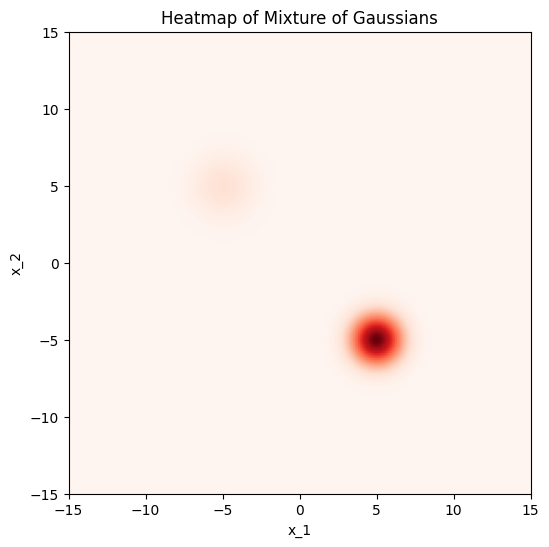

In [5]:
x_min = -15
x_max = 15
y_min = -15
y_max = 15

x, y = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
z = np.array([p_x(xi, yi) for xi, yi in zip(np.ravel(x), np.ravel(y))]).reshape(x.shape)

plt.figure(figsize=(6, 6))

extent = [x_min, x_max, y_min, y_max]

# PDF heatmap with corrected axis
plt.imshow(z, extent=extent, origin="lower", cmap="Reds")
plt.title("Heatmap of Mixture of Gaussians")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.show()

Generate Samples to Create a Toy Dataset

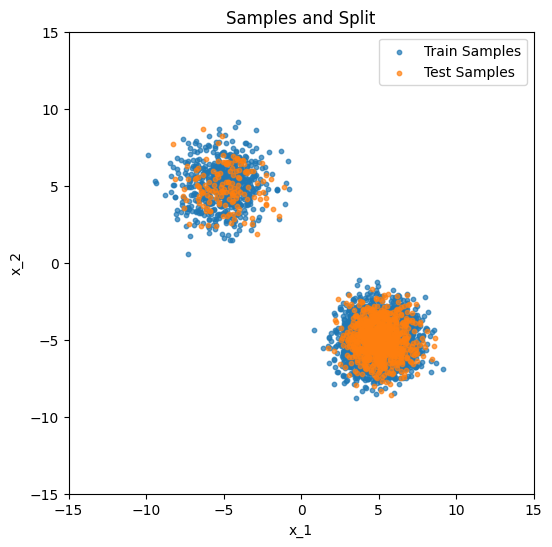

In [6]:
n_samples = 5000
train_split = 0.8
n_train = int(n_samples * train_split)

# Sampling from mixture of Gaussians
n1 = int(n_samples * w1)
n2 = n_samples - n1

samples1 = np.random.multivariate_normal(mean1, cov1, n1)
samples2 = np.random.multivariate_normal(mean2, cov2, n2)

samples = np.vstack((samples1, samples2))

# Shuffle the samples and split
indices = np.random.permutation(n_samples)
train_samples = samples[indices[:n_train]]
test_samples = samples[indices[n_train:]]

# Visualization
plt.figure(figsize=(6, 6))

plt.scatter(train_samples[:, 0], train_samples[:, 1], s=10, alpha=0.7, label="Train Samples")
plt.scatter(test_samples[:, 0], test_samples[:, 1], s=10, alpha=0.7, label="Test Samples")
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.title("Samples and Split")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
plt.show()


## Score Function (Ground-Truth)

* We use `gaussian_pdf(x, mean, cov)` function from the previous section.
* We should also use `w1`, `w2`, `mean1`, `mean2`, `cov1` and `cov2` to implement the `score_function_gt`.

In [7]:
def score_function_gt(x):
    """
      Calculates the score function (gradient of the log-probability) for the mixture of two multivariate Gaussian distributions.
      The mixture is predefined by parameters w1, w2, mean1, mean2, cov1 and cov2.

      Args:
          x: A 2D point where the score function is evaluated.

      Returns:
          numpy.ndarray: The score vector at point x, representing the gradients of
          the log-probability density function of the mixture at those points.

      Notes:
          The score function is derived analytically for the mixture:
          p(x) = w1 * N(x | mean1, cov1) + w2 * N(x | mean2, cov2)
          ∇log(p(x)) = ?
    """

    # Calculate Gaussian PDFs for each component
    pdf1 = gaussian_pdf(x, mean1, cov1)
    pdf2 = gaussian_pdf(x, mean2, cov2)

    # Mixture probability density function
    p_x = w1 * pdf1 + w2 * pdf2

    # Gradients of each component
    grad1 = np.linalg.solve(cov1, x - mean1)
    grad2 = np.linalg.solve(cov2, x - mean2)

    # Weighted average of gradients, normalized by p(x)
    score = (w1 * pdf1 * grad1 + w2 * pdf2 * grad2) / p_x

    return score


Visualization of the Score field

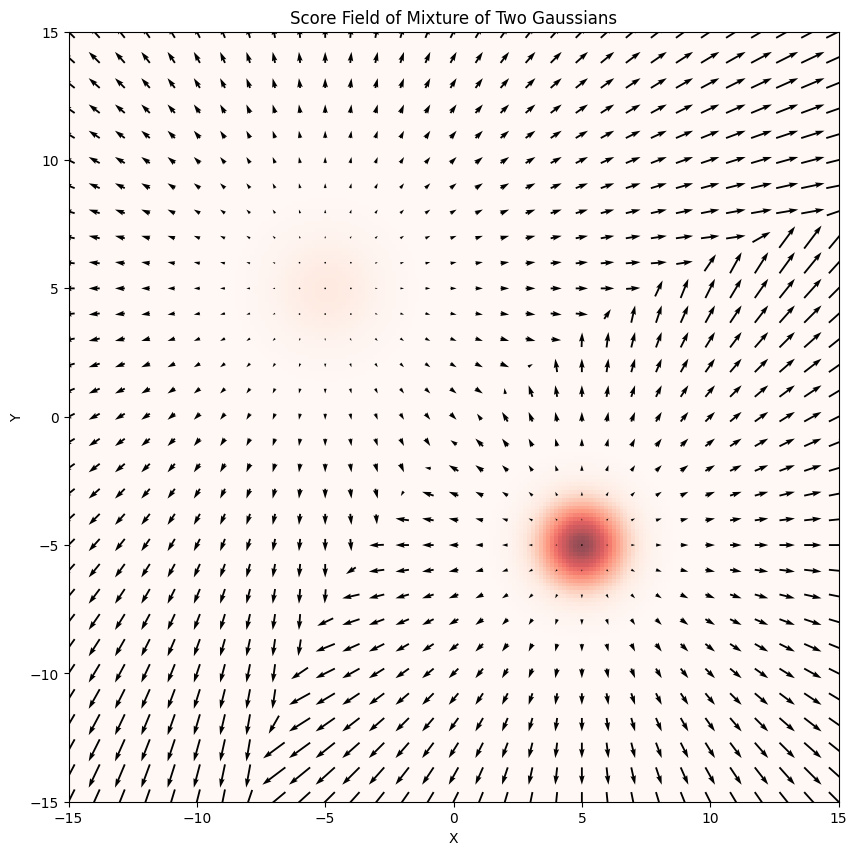

In [8]:
def plot_score_function(score_fn):
    # Mesh grid for the visualization
    x_vals = np.linspace(x_min, x_max, 31)
    y_vals = np.linspace(y_min, y_max, 31)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Calculate score vectors
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = np.array([X[i, j], Y[i, j]])
            score = score_fn(point)
            U[i, j], V[i, j] = score

    plt.quiver(X, Y, U, V, color="black", pivot="middle")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# Plot the score field
plt.figure(figsize=(10, 10))
plt.imshow(z, extent=extent, origin="lower", cmap="Reds", alpha=0.7)
plt.title("Score Field of Mixture of Two Gaussians")
plot_score_function(score_function_gt)

## Score Matching

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Add Noise

In [10]:
def add_noise(x, sigma):
    """
    Adds Gaussian noise to the input data.

    Args:
        x (torch.Tensor): The input data of shape [batch_size, 2].
        sigma (torch.Tensor): The standard deviation of the Gaussian noise to be added to each input, of shape [batch_size, 1].

    Returns:
        tuple:
            - x_noisy (torch.Tensor): The noisy data of the same shape as the input.
            - epsilon (torch.Tensor): The Gaussian noise added to the input, of the same shape as x.

    Notes:
        The function perturbs the input data `x` by adding Gaussian noise drawn from
        N(0, sigma²I) to create a noisy version of the data. Both the noisy data and the noise
        used are returned.
    """

    epsilon = torch.randn_like(x) * sigma
    x_noisy = x + epsilon


    return x_noisy, epsilon

Loss Function

In [11]:
def score_matching_loss(model, x_noisy, epsilon, sigma):
    """
    Calculates the score matching loss for a batch of noisy data points using noise perturbation.

    Args:
        model (torch.nn.Module): The score model that predicts the score function (gradient of log probability).
        x_noisy (torch.Tensor): The noisy input data.
        epsilon (torch.Tensor): The Gaussian noise added to the input.
        sigma (torch.Tensor): The standard deviation of the Gaussian noise.

    Returns:
        torch.Tensor: The computed score matching loss.
    """

    # Predicted score function from the model: model(x_noisy)
    score_pred = model(x_noisy, sigma)  # Assuming the model predicts the score

    # True score function is epsilon / sigma^2
    score_true = epsilon / (sigma ** 2)

    # The score matching loss is the squared difference between the predicted and true scores.
    loss = 0.5 * torch.mean((score_pred - score_true) ** 2)


    return loss


Training loop

In [12]:
def train_score_model(model, data, sigma_range, epochs=100, learning_rate=0.01):
    """
    Trains the score-based model over a range of sigma values using score matching loss.

    Args:
        model (torch.nn.Module): The score-based model to train.
        data (torch.Tensor): Training data, of shape [num_samples, 2].
        sigma_range (tuple): Range of sigma values to use during training, specified as [min_sigma, max_sigma].
        epochs (int, optional): Number of training epochs.
        learning_rate (float, optional): Learning rate for the optimizer.

    Returns:
        torch.Tensor: A batch of noisy data generated during training, for visualization purposes.
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0

        # Sample a batch of data and sigma from the range
        x_batch = data
        
        sigma = torch.rand(x_batch.size(0), 1) * (sigma_range[1] - sigma_range[0]) + sigma_range[0]

        # Add noise to the batch
        x_noisy, epsilon = add_noise(x_batch, sigma)

        # Calculate the score matching loss
        loss = score_matching_loss(model, x_noisy, epsilon, sigma)
        

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # # Log epoch loss
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data)}")

    # return a batch of noisy data for visualization purposes
    return x_noisy


### Model Architecture

In [13]:
class ScoreNet(nn.Module):
    def __init__(self):
        super(ScoreNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x, sigma):
        x_sigma = torch.cat([x, sigma], dim=1)
        return self.net(x_sigma)


In [14]:
# Helper function for visualization purposes
def visualize_score_field_model(model, samples=None, sigma=1, title="",):
    def fn(point):
        with torch.no_grad():
          pred = tuple(model(torch.tensor(point, dtype=torch.float).unsqueeze(0), torch.tensor([[sigma]])).squeeze().detach().numpy())
        return pred
    plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(samples[:,0], samples[:,1], bins=15, density=True, range=[[x_min,x_max],[y_min, y_max]])
    plt.imshow(heatmap.T, extent=extent, origin="lower", cmap="Reds", interpolation="bilinear", alpha=0.7)
    # plt.scatter(samples[:, 0], samples[:, 1], s=1)
    # plt.xlim(x_min, x_max)
    # plt.ylim(y_min, y_max)
    plt.title(title)
    plot_score_function(fn)

### Train Score matching with Constant Sigma

In [15]:
train_data = torch.tensor(train_samples).to(torch.float)

Example for sigma = 1

100%|██████████| 100/100 [00:00<00:00, 239.86it/s]


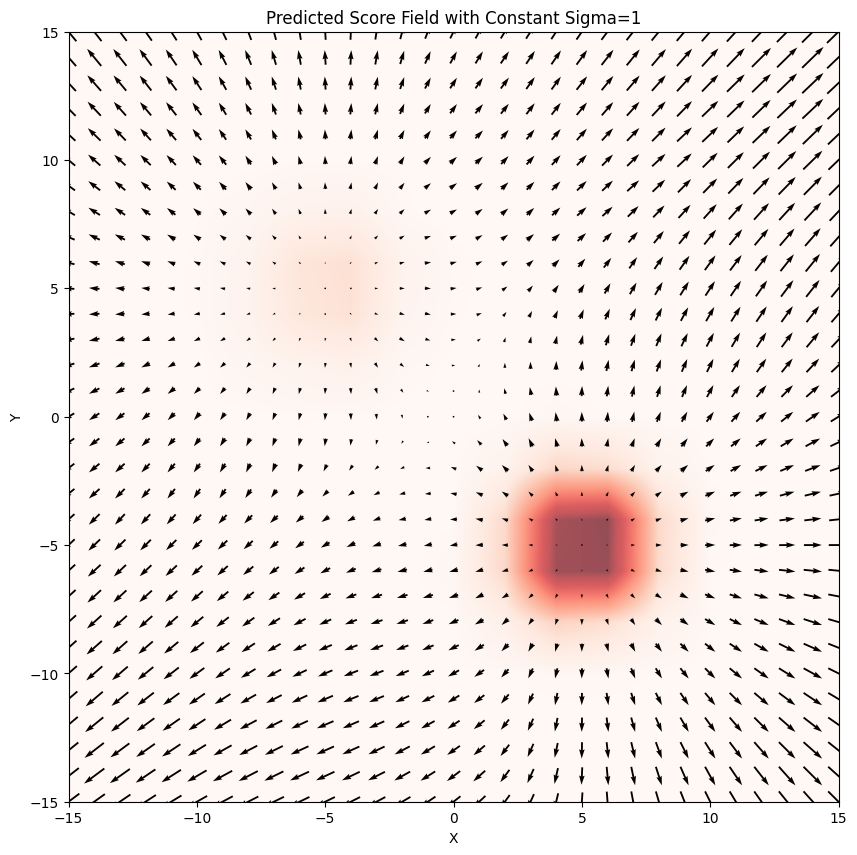

100%|██████████| 100/100 [00:00<00:00, 351.29it/s]


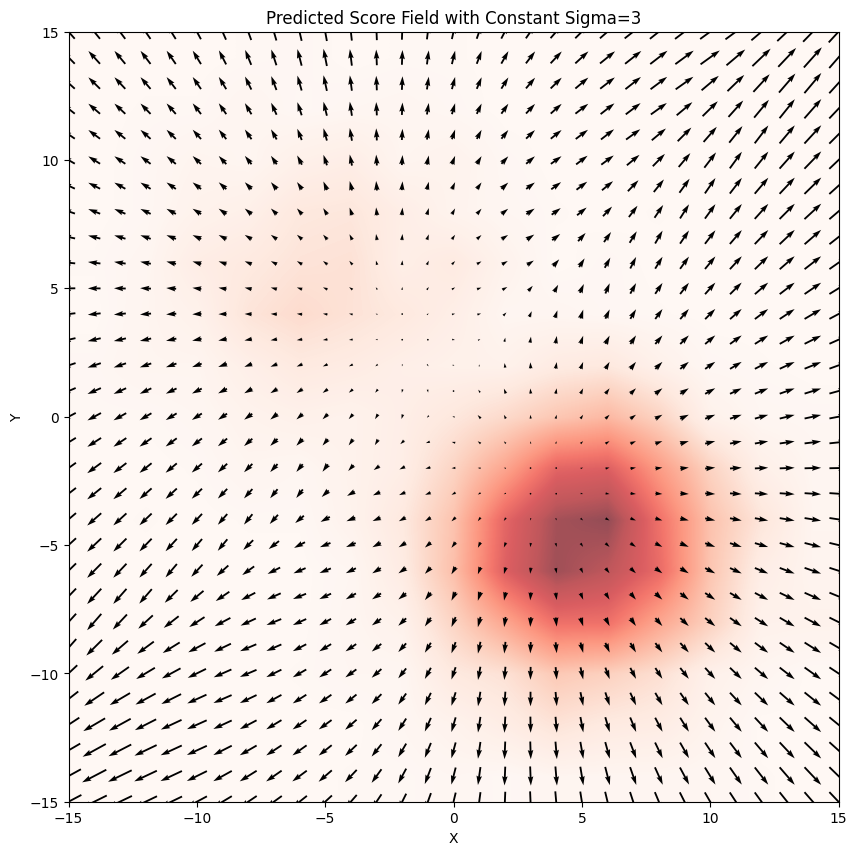

100%|██████████| 100/100 [00:00<00:00, 350.80it/s]


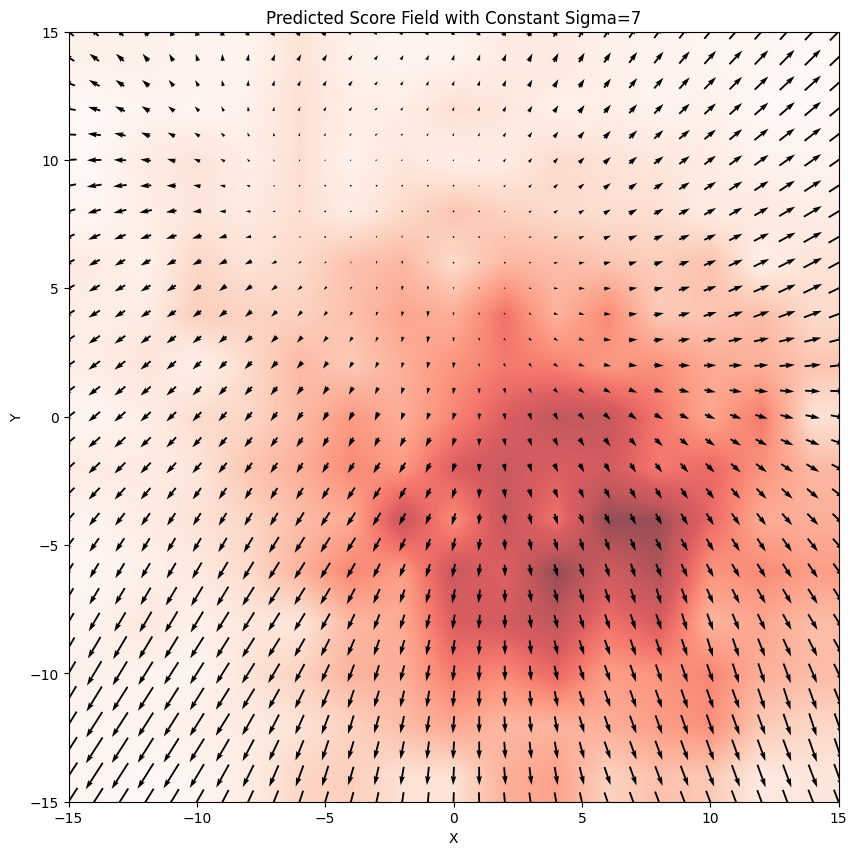

In [16]:
model_const_sigma_1 = ScoreNet()
samples = train_score_model(model_const_sigma_1, train_data, sigma_range=[1, 1])
visualize_score_field_model(model_const_sigma_1, samples, sigma=1, title="Predicted Score Field with Constant Sigma=1")

model_const_sigma_3 = ScoreNet()
samples = train_score_model(model_const_sigma_3, train_data, sigma_range=[3, 3])
visualize_score_field_model(model_const_sigma_3, samples, sigma=1, title="Predicted Score Field with Constant Sigma=3")

model_const_sigma_7 = ScoreNet()
samples = train_score_model(model_const_sigma_7, train_data, sigma_range=[7, 7])
visualize_score_field_model(model_const_sigma_7, samples, sigma=1, title="Predicted Score Field with Constant Sigma=7")

In [17]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    x_t = torch.randn((nsamples, 2))  # (nsamples, 2)
    time_pts = torch.linspace(1, 0, 1000)  # (ntime_pts,)
    beta = lambda t: 0.1 + (20 - 0.1) * t
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(x_t, t.expand(x_t.shape[0], 1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5
    return x_t

samples = generate_samples(model_const_sigma_1, 1000).detach()


## Sampling

In [18]:
num_steps = 10
step_size = 1

### Two Methods for Sampling

In [19]:
def deterministic_sampling(model, start_point, sigma_t, step_size, num_steps):
    """
    Performs deterministic sampling based on the score function model.

    Args:
        model (torch.nn.Module): The trained score function model.
        start_point (torch.Tensor): The initial points for sampling, of shape [batch_size, 2].
        sigma_t (torch.Tensor): A tensor of noise scales for each step, of shape [num_steps, batch_size, 1].
        step_size (float): The step size for moving in the direction of the score function.
        num_steps (int): The number of steps to perform.

    Returns:
        list[torch.Tensor]: A list of tensors representing the trajectory of points at each step.

    Notes:
        The trajectory is computed by moving the points in the direction of the score function
        gradient at each step without adding randomness.
    """
    current_point = start_point.detach()
    trajectory = [current_point]

    with torch.inference_mode():
        for t in range(num_steps):
            # Extract the sigma for this step
            sigma = sigma_t[t]

            # Predict the score using the model
            score = -1 * model(current_point, sigma)

            # Update the current point deterministically
            current_point = current_point + step_size * score

            # Append the new point to the trajectory
            trajectory.append(current_point)
            
    return trajectory


def langevin_sampling(model, start_point, sigma_t, step_size, num_steps):
    """
    Performs Langevin dynamics sampling based on the score function model.

    Args and Outputs similar to the previous function.

    Notes:
        The trajectory is computed by moving the points in the direction of the score function
        gradient at each step, with added Gaussian noise with a specific scale to introduce stochasticity.
    """
    current_point = start_point.detach()
    trajectory = [current_point]

    with torch.inference_mode():
        for t in range(num_steps):
            # Extract the sigma for this step
            sigma = sigma_t[t]

            # Predict the score using the model
            score = -1 * model(current_point, sigma)

            # Add a stochastic Gaussian noise component
            step_tensor = torch.tensor(step_size, device=current_point.device)
            noise = torch.randn_like(current_point) * torch.sqrt(2 * step_tensor)

            # Update the current point with Langevin dynamics
            current_point = current_point + step_size * score + noise

            # Append the new point to the trajectory
            trajectory.append(current_point)

    return trajectory


In [20]:
start_point = torch.rand(1,2) * (x_max-x_min) + x_min

deterministic_traj = deterministic_sampling(model_const_sigma_1, start_point, torch.ones(num_steps, 1, 1), step_size, num_steps)
langevin_traj = langevin_sampling(model_const_sigma_1, start_point, torch.ones(num_steps, 1, 1), step_size, num_steps)


Visualization

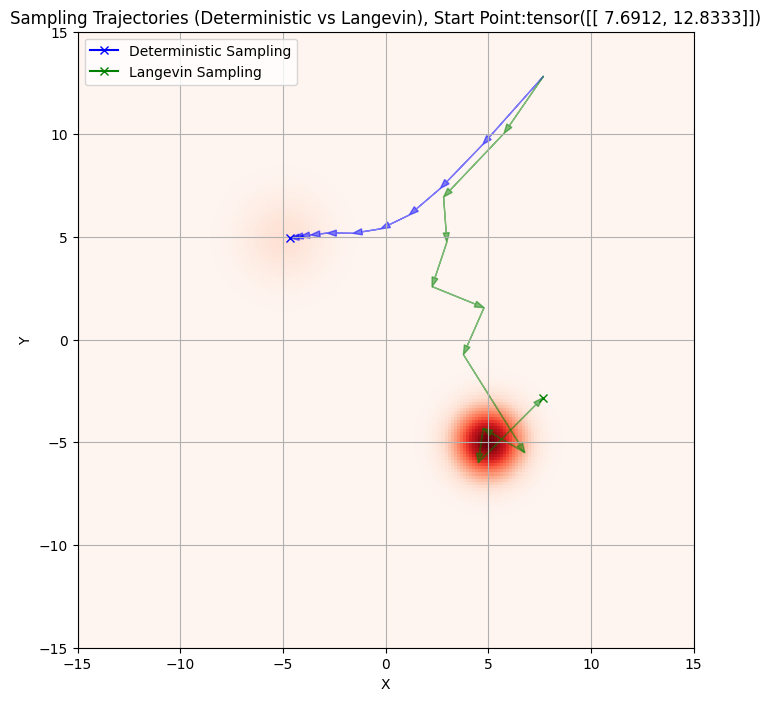

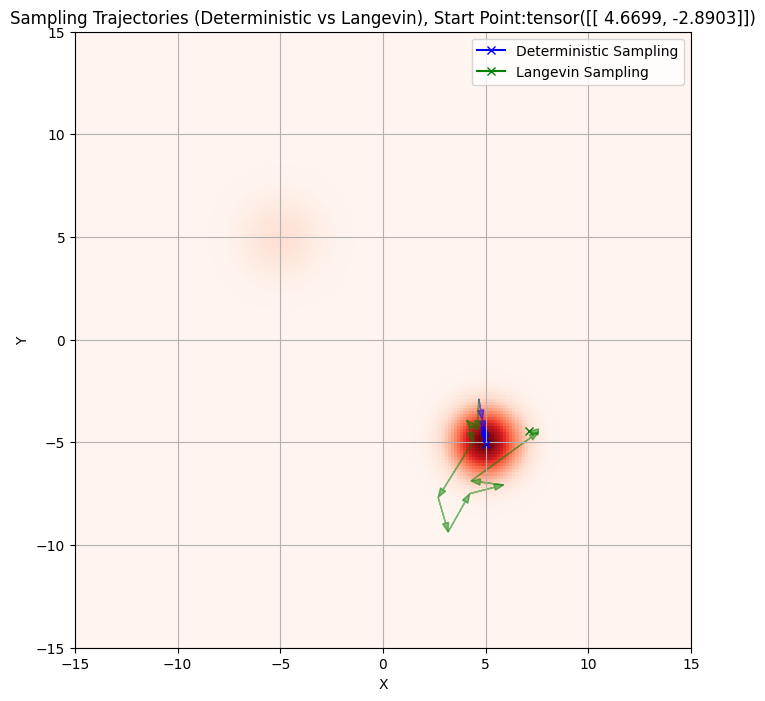

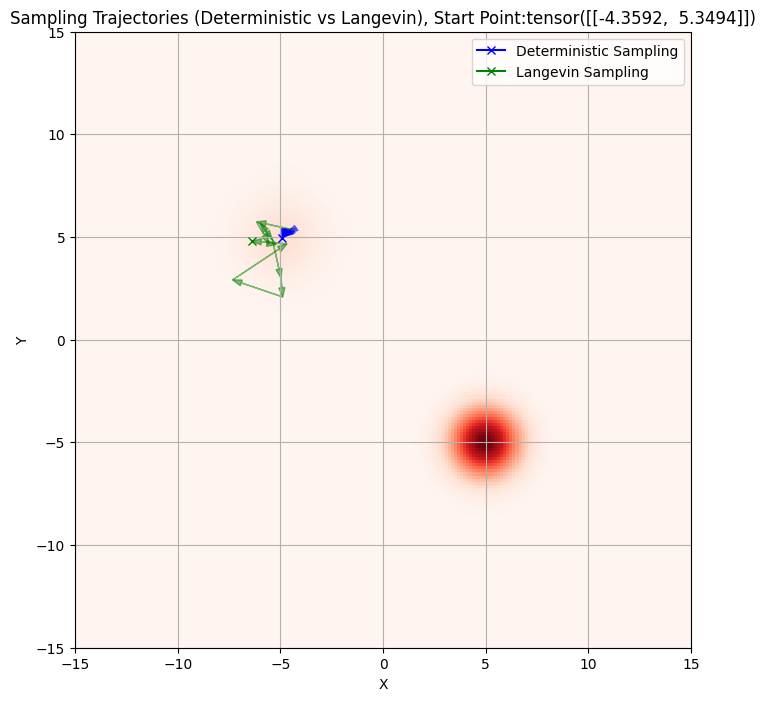

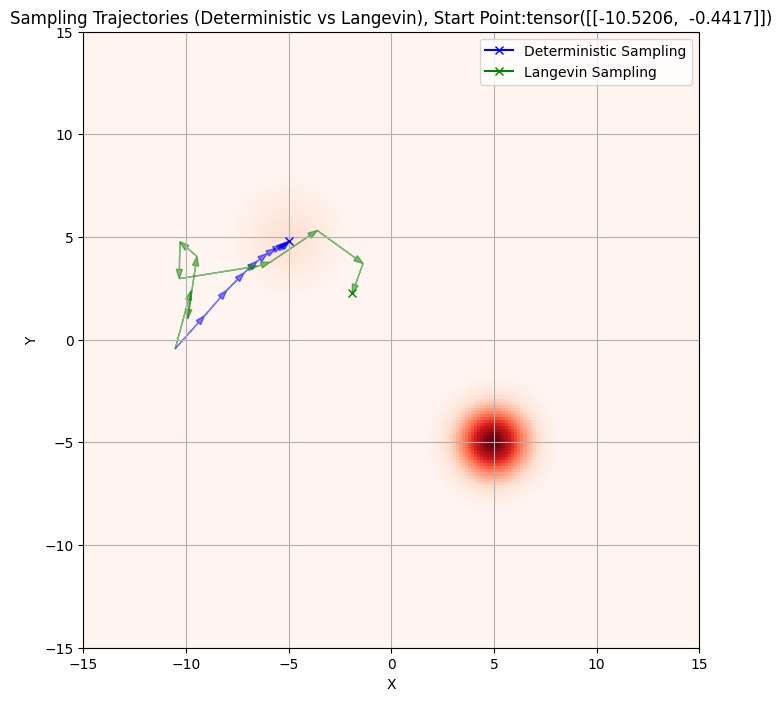

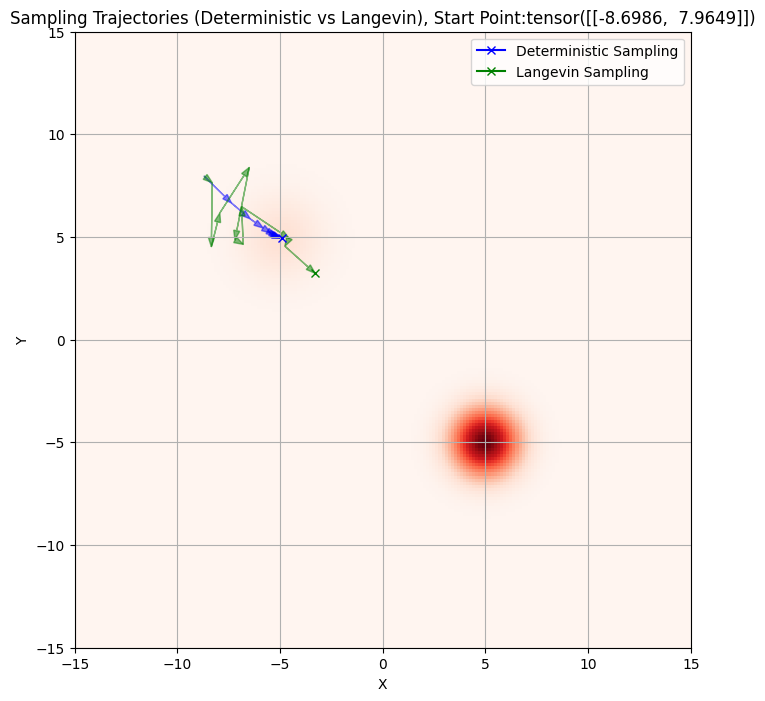

In [21]:
for _ in range(5):
    start_point = torch.rand(1,2) * (x_max-x_min) + x_min
    
    deterministic_traj = deterministic_sampling(model_const_sigma_1, start_point, torch.ones(num_steps, 1, 1), step_size, num_steps)
    langevin_traj = langevin_sampling(model_const_sigma_1, start_point, torch.ones(num_steps, 1, 1), step_size, num_steps)
    
    # Convert trajectories to arrays
    deterministic_traj = np.concatenate(deterministic_traj, axis=0)
    langevin_traj = np.concatenate(langevin_traj, axis=0)
    
    
    plt.figure(figsize=(8, 8))
    
    # Plot deterministic trajectory
    plt.plot(deterministic_traj[-1, 0], deterministic_traj[-1, 1], marker="x", color="blue", label="Deterministic Sampling")
    for i in range(len(deterministic_traj) - 1):
        plt.arrow(deterministic_traj[i, 0], deterministic_traj[i, 1],
                  deterministic_traj[i + 1, 0] - deterministic_traj[i, 0],
                  deterministic_traj[i + 1, 1] - deterministic_traj[i, 1],
                  color="blue", head_width=0.3, length_includes_head=True, alpha=0.5)
    
    # Plot Langevin trajectory
    plt.plot(langevin_traj[-1, 0], langevin_traj[-1, 1], marker="x", color="green", label="Langevin Sampling")
    for i in range(len(langevin_traj) - 1):
        plt.arrow(langevin_traj[i, 0], langevin_traj[i, 1],
                  langevin_traj[i + 1, 0] - langevin_traj[i, 0],
                  langevin_traj[i + 1, 1] - langevin_traj[i, 1],
                  color="green", head_width=0.3, length_includes_head=True, alpha=0.5)
    
    
    plt.legend()
    plt.imshow(z, extent=extent, origin="lower", cmap="Reds")
    plt.title(f"Sampling Trajectories (Deterministic vs Langevin), Start Point:{start_point}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.grid(True)
    plt.show()


### Generate 1000 samples with each method
*Note: Sample all starting points at once, or it’s gonna take ages!*

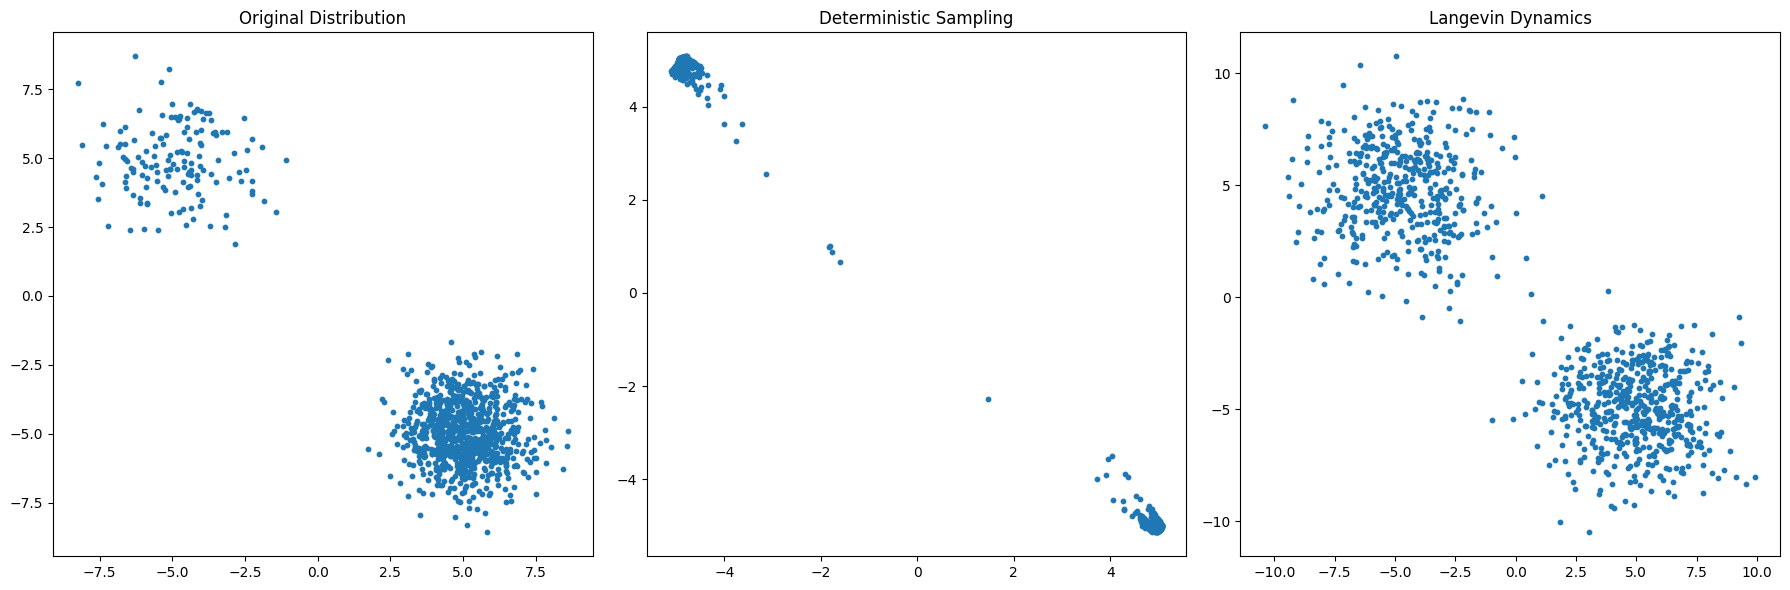

In [22]:
# Number of random starting points
num_points = 1000

# Generate random initial points for sampling
start_points = torch.rand(num_points, 2) * (x_max - x_min) + x_min  # Uniformly distributed in range [x_min, x_max]

# Prepare sigma tensor for all steps
sigma_t = torch.ones(num_steps, num_points, 1)  # Constant sigma value for each step

# Perform deterministic sampling for all starting points
with torch.inference_mode():
    deterministic_samples = deterministic_sampling(
        model_const_sigma_1, start_points, sigma_t, step_size, num_steps
    )[-1].cpu().numpy()  # Use the last step from the trajectory

# Perform Langevin dynamics sampling for all starting points
with torch.inference_mode():
    langevin_trajectories = []
    for i in range(num_points):
        langevin_trajectories.append(
            langevin_sampling(
                model_const_sigma_1, start_points[i:i+1], sigma_t[:, i:i+1], step_size, num_steps
            )[-1]
        )
    langevin_samples = torch.cat(langevin_trajectories, dim=0).cpu().numpy()


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(test_samples[:, 0], test_samples[:, 1], s=10)
axes[0].set_title("Original Distribution")

axes[1].scatter(deterministic_samples[:, 0], deterministic_samples[:, 1], s=10)
axes[1].set_title("Deterministic Sampling")

axes[2].scatter(langevin_samples[:, 0], langevin_samples[:, 1], s=10)
axes[2].set_title("Langevin Dynamics")

plt.tight_layout()
plt.show()

## Final Part

### Score matching with different values for sigma
Train a score-based model using a range of sigma values (e.g., [1, 20]) during training, using the functions developed in previous sections.

*Note: You may need to increase the number of epochs for effective training.*

100%|██████████| 1024/1024 [00:03<00:00, 338.54it/s]


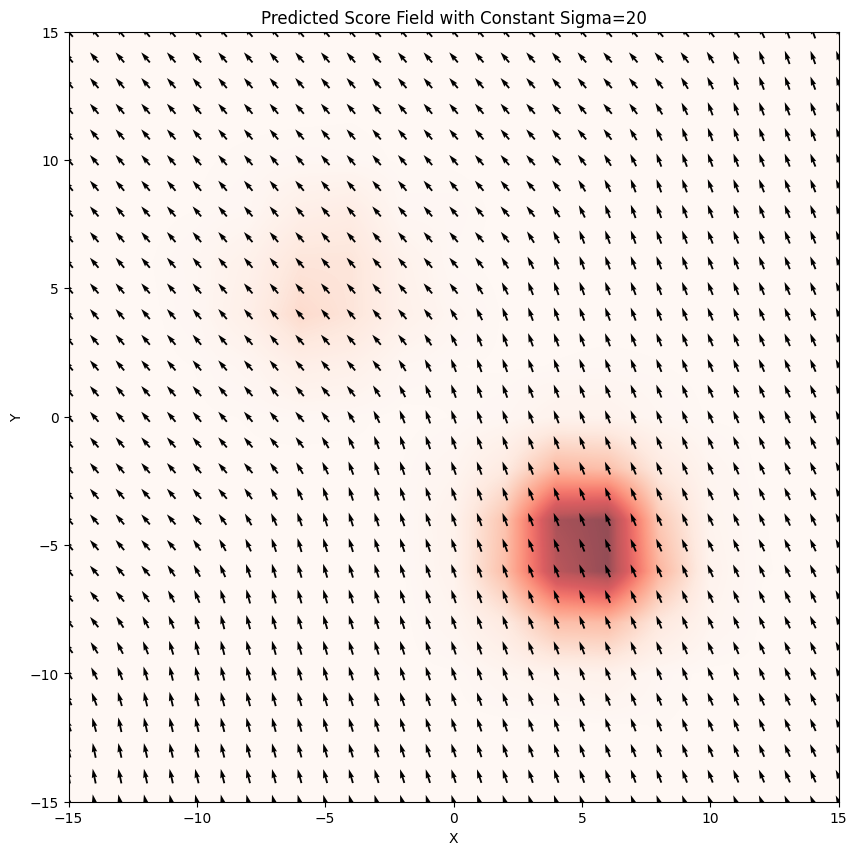

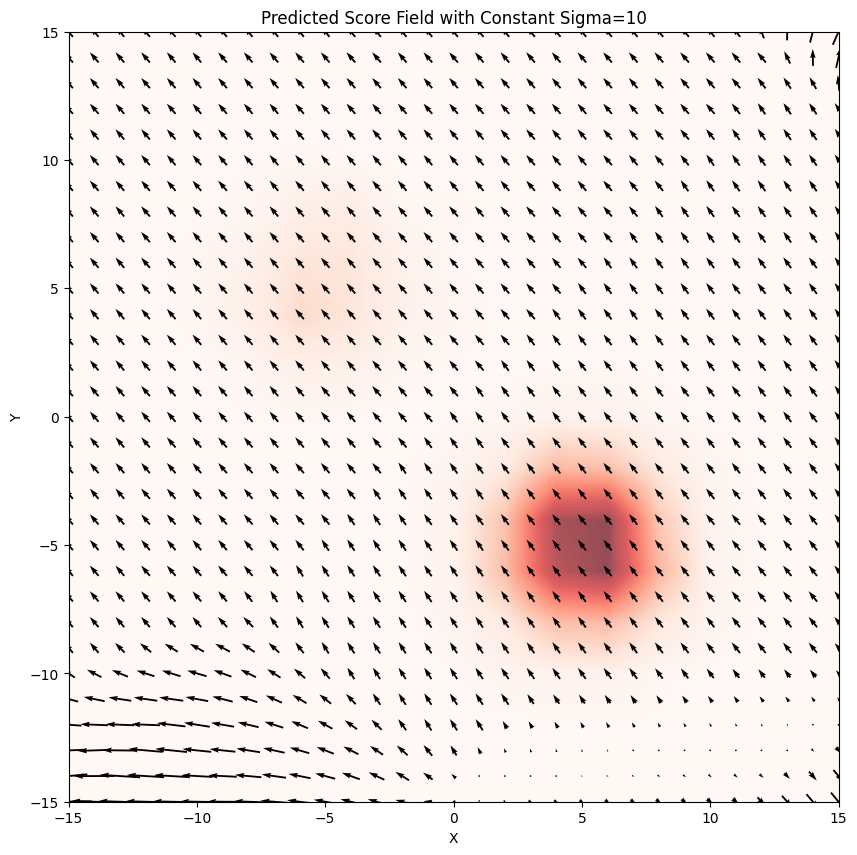

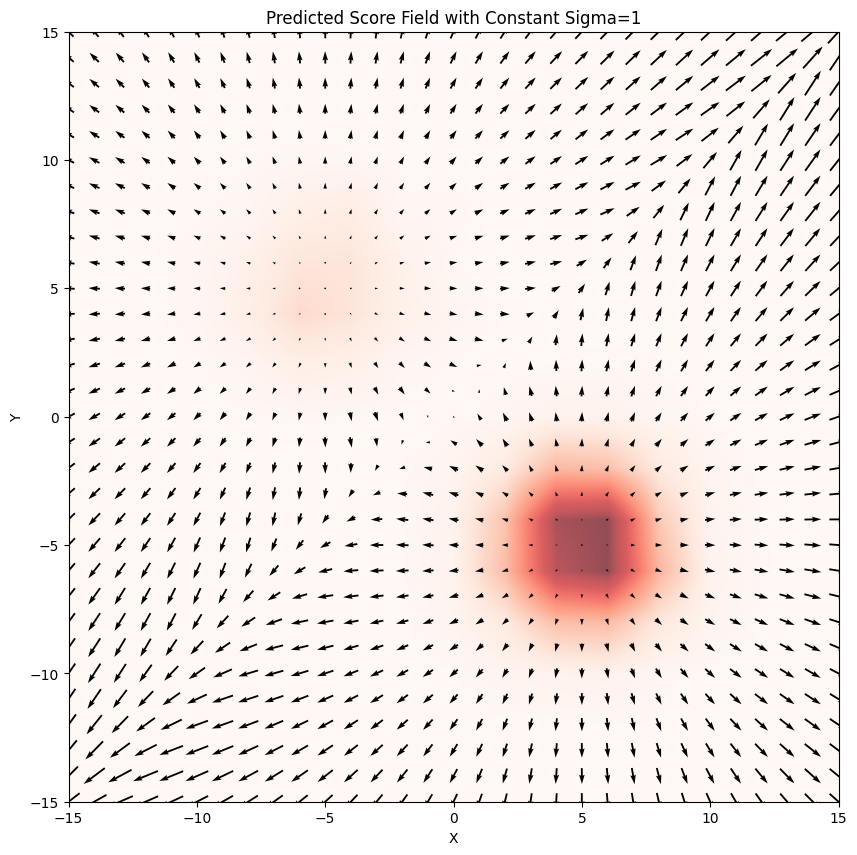

In [30]:
# Define the model
model_sigma_range = ScoreNet()

# Train the model with a sigma range of [1, 20]
sigma_range = [1, 20]
epochs = 1
learning_rate = 0.01

# Train the score-based model
for i in range(20, 1, -1):
    if i % 2 == 0:
        epochs *= 2
    # if i % 15 == 0:
    #     learning_rate *= 0.1
    trained_samples = train_score_model(model_sigma_range, train_data, [i-1, i], epochs=epochs, learning_rate=learning_rate)
    
visualize_score_field_model(model_sigma_range, trained_samples, sigma=20, title="Predicted Score Field with Constant Sigma=20")
visualize_score_field_model(model_sigma_range, trained_samples, sigma=10, title="Predicted Score Field with Constant Sigma=10")
visualize_score_field_model(model_sigma_range, trained_samples, sigma=1, title="Predicted Score Field with Constant Sigma=1")


### Sampling with Noise Schedule
Apply the sampling methods implemented earlier, using a sigma schedule. Begin with a high sigma value and progressively decrease it over the sampling steps.

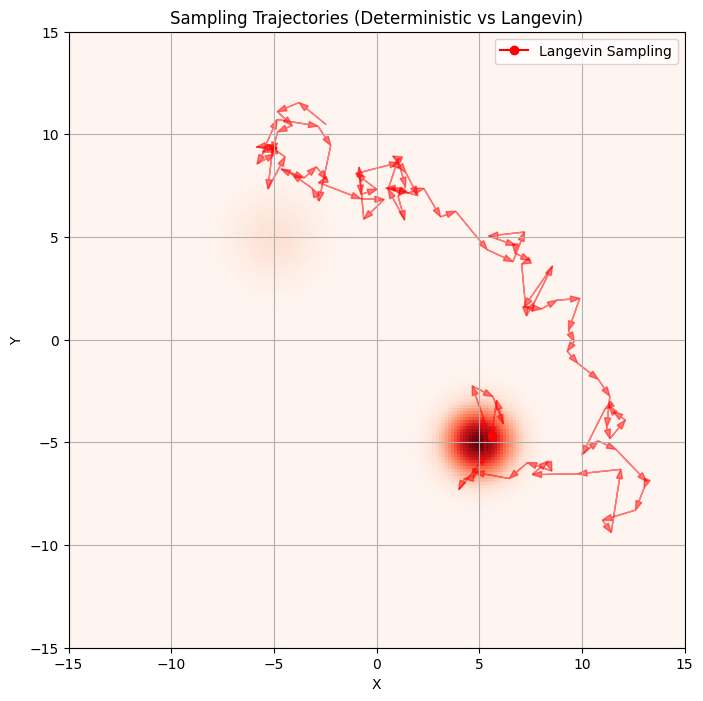

In [33]:
def annealed_langevin_sampling(model, start_point, sigma_start, sigma_end, step_size, num_steps):
    """
    Performs Annealed Langevin Dynamics sampling based on the score function model.
    The noise scale sigma is annealed from sigma_start to sigma_end over num_steps.
    """
    current_point = start_point.detach()
    trajectory = [current_point]

    # Create a schedule for sigma values from sigma_start to sigma_end
    sigma_schedule = torch.linspace(sigma_start, sigma_end, num_steps, device=current_point.device).view(num_steps, 1, 1)

    with torch.inference_mode():
        for t in range(num_steps):
            # Extract the sigma for this step
            sigma = sigma_schedule[t]

            # Predict the score using the model
            score = -1 * model(current_point, sigma)

            # Add a stochastic Gaussian noise component
            step_tensor = torch.tensor(step_size, device=current_point.device)
            noise = torch.randn_like(current_point) * torch.sqrt(step_tensor)

            # Update the current point with Langevin dynamics
            current_point = current_point + step_size/2 * score + noise

            # Append the new point to the trajectory
            trajectory.append(current_point)

    return trajectory

# print(sigma_t.shape)
start_point = torch.rand(1,2) * (x_max-x_min) + x_min
sigma_start = 20
sigma_end = 1
step_size = 1
num_steps = 100

# Perform Annealed Langevin Dynamics sampling
annealed_trajectory = annealed_langevin_sampling(model_sigma_range, start_point, sigma_start, sigma_end, step_size, num_steps)
# print(trajectory)

# Convert trajectory to a tensor for analysis
# langevin_traj = torch.stack(trajectory)

ann_langevin_traj = np.concatenate(annealed_trajectory, axis=0)

plt.figure(figsize=(8, 8))
# Plot Langevin trajectory
plt.plot(ann_langevin_traj[-1, 0], ann_langevin_traj[-1, 1], marker="o", color="red", label="Langevin Sampling")
for i in range(len(ann_langevin_traj) - 1):
    plt.arrow(ann_langevin_traj[i, 0], ann_langevin_traj[i, 1],
              ann_langevin_traj[i + 1, 0] - ann_langevin_traj[i, 0],
              ann_langevin_traj[i + 1, 1] - ann_langevin_traj[i, 1],
              color="red", head_width=0.3, length_includes_head=True, alpha=0.5)


plt.legend()
plt.imshow(z, extent=extent, origin="lower", cmap="Reds")
plt.title("Sampling Trajectories (Deterministic vs Langevin)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.grid(True)
plt.show()


100%|██████████| 1000/1000 [00:14<00:00, 67.94it/s]


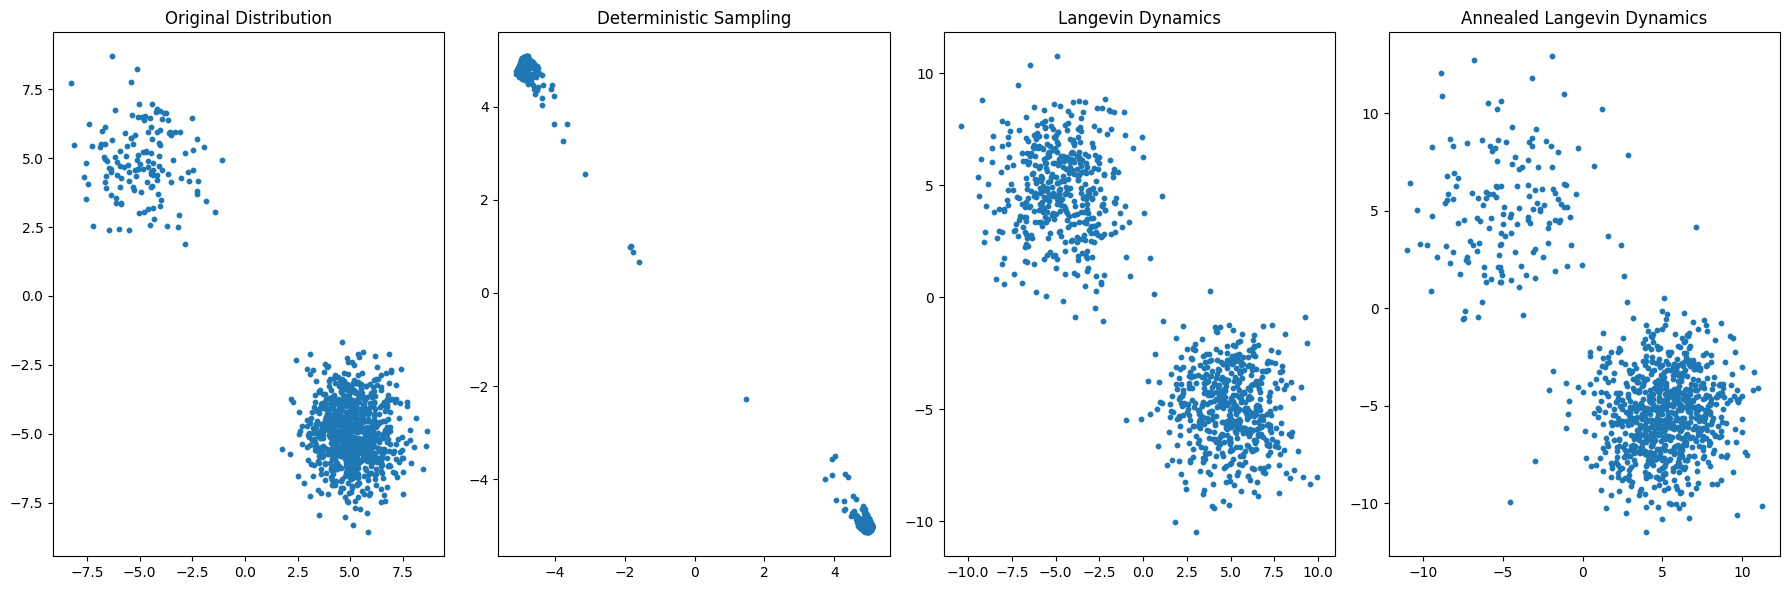

In [34]:
num_points = 1000

start_points = torch.rand(num_points, 2) * (x_max - x_min) + x_min

# Annealed Langevin sampling
ann_langevin_samples = []
with torch.inference_mode():
    for i in tqdm(range(num_points)):
        start_point = torch.rand(1,2) * (x_max-x_min) + x_min
        trajectory = annealed_langevin_sampling(
            model=model_sigma_range,
            start_point=start_point,
            sigma_start=sigma_start,
            sigma_end=sigma_end,
            step_size=1,
            num_steps=100
        )
        ann_langevin_samples.append(trajectory[-1].cpu().numpy())

ann_langevin_samples = np.array(ann_langevin_samples)


fig, axes = plt.subplots(1, 4, figsize=(18, 6))

axes[0].scatter(test_samples[:, 0], test_samples[:, 1], s=10)
axes[0].set_title("Original Distribution")

axes[1].scatter(deterministic_samples[:, 0], deterministic_samples[:, 1], s=10)
axes[1].set_title("Deterministic Sampling")

axes[2].scatter(langevin_samples[:, 0], langevin_samples[:, 1], s=10)
axes[2].set_title("Langevin Dynamics")

axes[3].scatter(ann_langevin_samples[:, 0, 0], ann_langevin_samples[:, 0, 1], s=10)
axes[3].set_title("Annealed Langevin Dynamics")

plt.tight_layout()
plt.show()



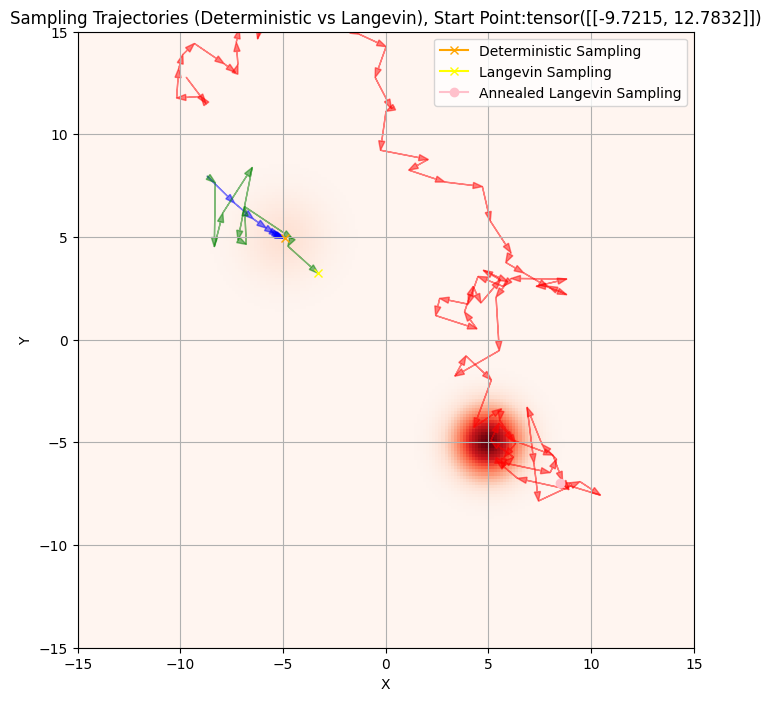

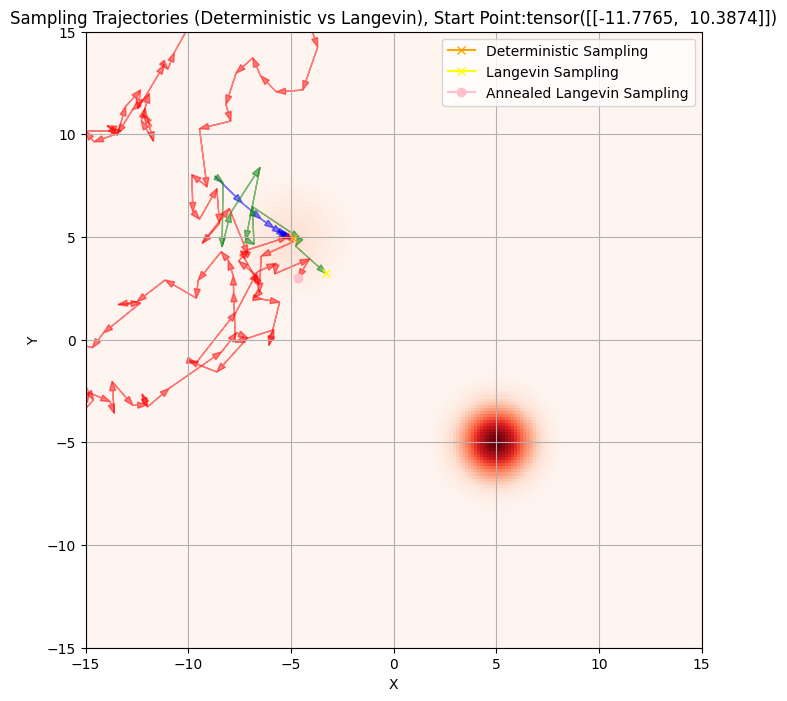

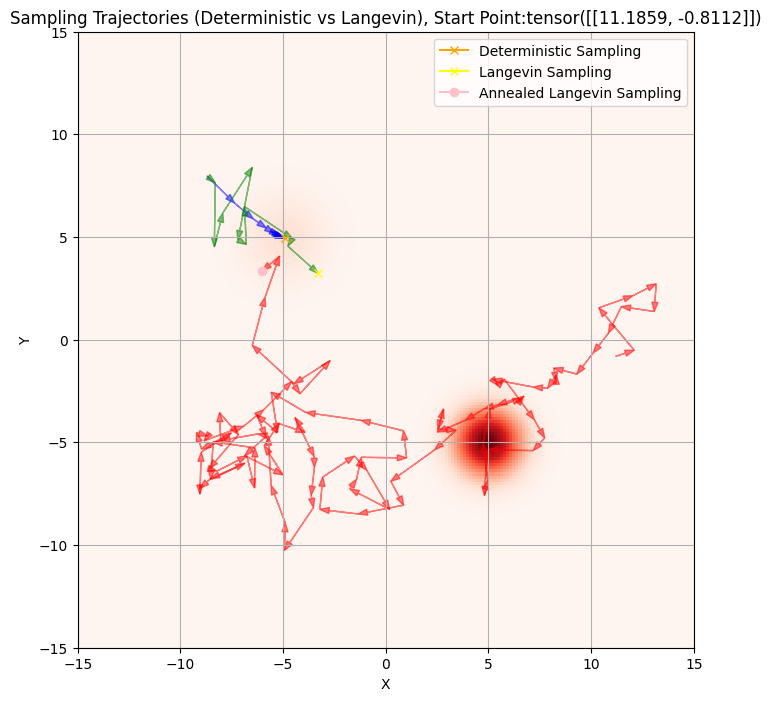

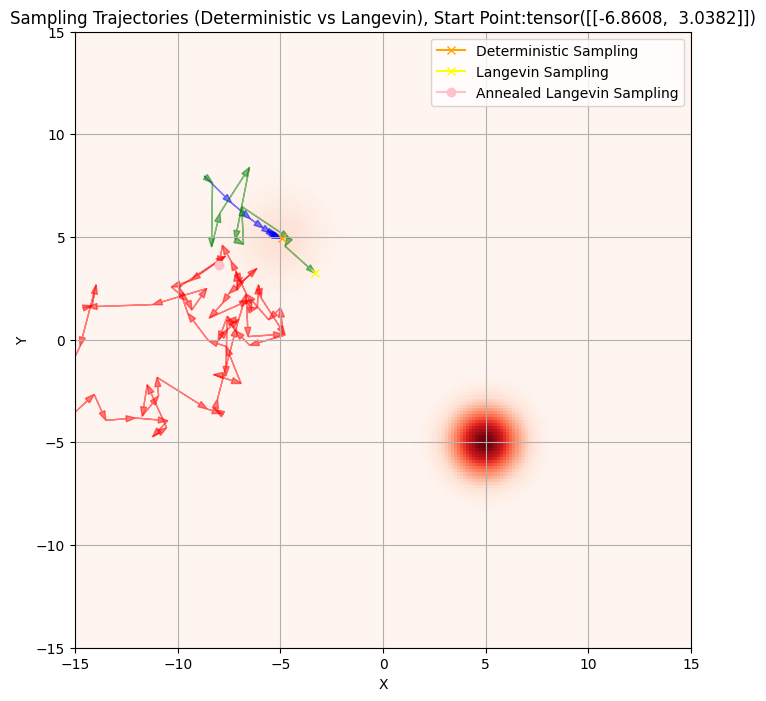

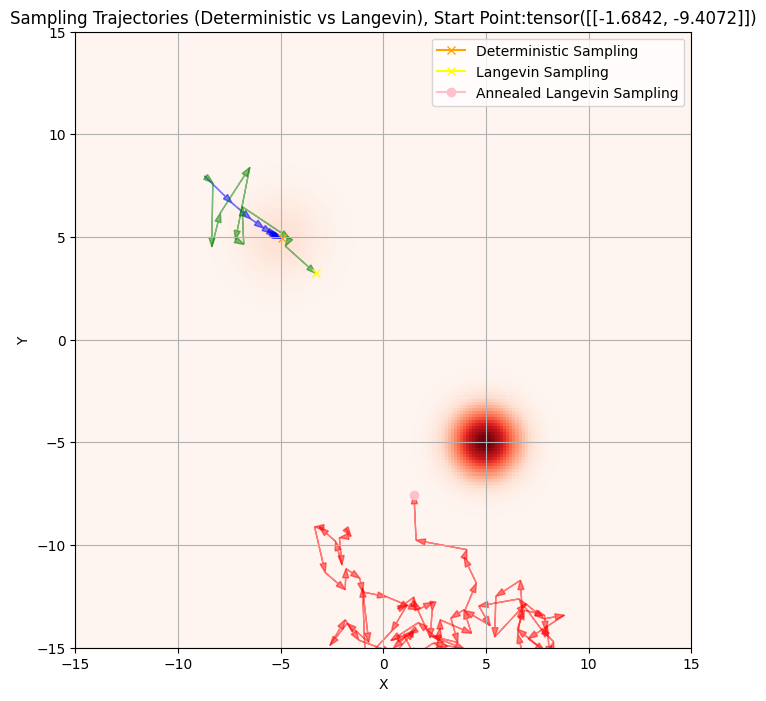

In [35]:
for _ in range(5):
    start_point = torch.rand(1,2) * (x_max-x_min) + x_min
    
    # deterministic_traj = deterministic_sampling(model_sigma_range, start_point, torch.ones(num_steps, 1, 1), step_size, 10)
    # langevin_traj = langevin_sampling(model_sigma_range, start_point, torch.ones(num_steps, 1, 1), step_size, 10)
    ann_langevin_traj = annealed_langevin_sampling(model_sigma_range, start_point, sigma_start, sigma_end, step_size, num_steps)
    
    # # Convert trajectories to arrays
    # deterministic_traj = np.concatenate(deterministic_traj, axis=0)
    # langevin_traj = np.concatenate(langevin_traj, axis=0)
    ann_langevin_traj = np.concatenate(ann_langevin_traj, axis=0)
    
    
    plt.figure(figsize=(8, 8))
    
    # Plot deterministic trajectory
    plt.plot(deterministic_traj[-1, 0], deterministic_traj[-1, 1], marker="x", color="orange", label="Deterministic Sampling")
    for i in range(len(deterministic_traj) - 1):
        plt.arrow(deterministic_traj[i, 0], deterministic_traj[i, 1],
                  deterministic_traj[i + 1, 0] - deterministic_traj[i, 0],
                  deterministic_traj[i + 1, 1] - deterministic_traj[i, 1],
                  color="blue", head_width=0.3, length_includes_head=True, alpha=0.5)
    
    # Plot Langevin trajectory
    plt.plot(langevin_traj[-1, 0], langevin_traj[-1, 1], marker="x", color="yellow", label="Langevin Sampling")
    for i in range(len(langevin_traj) - 1):
        plt.arrow(langevin_traj[i, 0], langevin_traj[i, 1],
                  langevin_traj[i + 1, 0] - langevin_traj[i, 0],
                  langevin_traj[i + 1, 1] - langevin_traj[i, 1],
                  color="green", head_width=0.3, length_includes_head=True, alpha=0.5)

    plt.plot(ann_langevin_traj[-1, 0], ann_langevin_traj[-1, 1], marker="o", color="pink", label="Annealed Langevin Sampling")
    for i in range(len(ann_langevin_traj) - 1):
        plt.arrow(ann_langevin_traj[i, 0], ann_langevin_traj[i, 1],
                  ann_langevin_traj[i + 1, 0] - ann_langevin_traj[i, 0],
                  ann_langevin_traj[i + 1, 1] - ann_langevin_traj[i, 1],
                  color="red", head_width=0.3, length_includes_head=True, alpha=0.5)
    
    
    plt.legend()
    plt.imshow(z, extent=extent, origin="lower", cmap="Reds")
    plt.title(f"Sampling Trajectories (Deterministic vs Langevin), Start Point:{start_point}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.grid(True)
    plt.show()
